# Wind Impact on Blending Agent Performance

How robust is the RL architecture trained on to blend other RL policies to all wind?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from utilities import get_agent
from environments import OctorotorEnvSelector
from systems.pid_agent import PIDAgent
from multirotor.helpers import DataLog

In [2]:
best_agent = PIDAgent()

best_params = {'steps_u':50, 'scaling_factor':0, 'window_distance':10}

In [3]:
best_params

{'steps_u': 50, 'scaling_factor': 0, 'window_distance': 10}

In [4]:
env_selector = OctorotorEnvSelector()
square_wpts = np.array([[100,0,30], [100,100,30], [0,100,30], [0,0,30]])

In [5]:
def get_tte(initial_pos: tuple, waypoints: np.ndarray, x: np.ndarray, y:np.ndarray, z:np.ndarray) -> np.ndarray:
        """
        Calculates the trajectory tracking error. 
        The distance between the current point and the vector between previous and next wp. Uses ||v1 x v2|| / ||v1||.

        Parameters
        ----------
        initial_pos : tuple  
            the initial position of the UAV.
        waypoints : np.ndarray 
            the reference positions at each point in time.
        x : np.ndarray 
            the x positions of the UAV.
        y : np.ndarray 
            the y positions of the UAV.
        z : np.ndarray
            the z positions of the UAV.

        Returns
        -------
        np.ndarray 
            the trajectory tracking error at each point in time.
        """
        ttes = []
        prev = initial_pos
        for i, waypoint in enumerate(waypoints):
            if i > 0 and not np.array_equal(waypoints[i-1], waypoints[i]):
                prev = waypoints[i-1]

            v1 = waypoint - prev
            v2 = np.array([x[i],y[i],z[i]]) - prev
            tte = np.linalg.norm(np.cross(v1, v2)) / (np.linalg.norm(v1) + 1e-6)
            ttes.append(tte)
                
        return np.array(ttes)

In [6]:
def toc(tte: np.ndarray):
    corridor = 5
    return best_params['steps_u'] * len(tte[tte > corridor]) / 100

In [7]:
def completed_mission(waypoints: np.ndarray, x: np.ndarray, y: np.ndarray, z: np.ndarray, radius: float = 0.65):
        for waypoint in waypoints:
            reached_waypoint = False

            for position in zip(x,y,z):
                dist = np.linalg.norm(waypoint - position)

                if dist <= radius:
                    reached_waypoint = True
                    break

            if not reached_waypoint:
                return False
            
        return True

In [8]:
def run_trajectory(env_selector, wind_ranges: np.ndarray, agent, params):
    env = env_selector.get_env("sliding", params, wind_ranges, square_wpts, start_alt=30, has_turbulence=True)
    done = False
    state = np.array(env.reset(), dtype=np.float32)
    log = DataLog(env.base_env.vehicle, env.base_env.ctrl,
                      other_vars=('reward',))
    while not done:
        action = agent.predict(state, deterministic=True)[0]
        state, reward, done, info = env.step(action)
        state = np.array(state, dtype=np.float32)
        log.log(reward=reward)
        print(env.base_env.wind_x, env.base_env.wind_y, env.base_env.wind_z)

    log.done_logging()
    return log, info

In [9]:
wind_range_dict = {
    'zero': [(0,0), (0,0), (0,0)],
    'n5': [(0,0), (5,5), (0,0)],
    'n7': [(0,0), (7,7), (0,0)],
    'n10': [(0,0), (10,10), (0,0)],
    's5': [(0,0), (-5,-5), (0,0)],
    's7': [(0,0), (-7,-7), (0,0)],
    's10': [(0,0), (-10,-10), (0,0)],
    'e5': [(5,5), (0,0), (0,0)],
    'e7': [(7,7), (0,0), (0,0)],
    'e10': [(10,10), (0,0), (0,0)],
    'w5': [(-5,-5), (0,0), (0,0)],
    'w7': [(-7,-7), (0,0), (0,0)],
    'w10': [(-10,-10), (0,0), (0,0)],
    'nw5': [(-3.53553391,-3.53553391), (3.53553391,3.53553391), (0,0)],
    'nw7': [(-4.94974747,-4.94974747), (4.94974747,4.94974747), (0,0)],
    'nw10': [(-7.07106781,-7.07106781), (7.07106781,7.07106781), (0,0)],
    'sw5': [(-3.53553391,-3.53553391), (-3.53553391,-3.53553391), (0,0)],
    'sw7': [(-4.94974747,-4.94974747), (-4.94974747,-4.94974747), (0,0)],
    'sw10': [(-7.07106781,-7.07106781), (-7.07106781,-7.07106781), (0,0)],
    'ne5': [(3.53553391,3.53553391), (3.53553391,3.53553391), (0,0)],
    'ne7': [(4.94974747,4.94974747), (4.94974747,4.94974747), (0,0)],
    'ne10': [(7.07106781,7.07106781), (7.07106781,7.07106781), (0,0)],
    'se5': [(3.53553391,3.53553391), (-3.53553391,-3.53553391), (0,0)],
    'se7': [(4.94974747,4.94974747), (-4.94974747,-4.94974747), (0,0)],
    'se10': [(7.07106781,7.07106781), (-7.07106781,-7.07106781), (0,0)],
}

In [10]:
log, info = run_trajectory(env_selector, wind_range_dict['n7'], best_agent, best_params)

0.0 7.0 0.0
0.00677456768249924 6.945067214859612 -0.0814986299526333
-0.027601160482708477 6.945219173585215 -0.050829412081207656
-0.14187631306259163 7.02521834044319 -0.030316813271006427
-0.12069842501621343 6.925273196484661 -0.017738639511916413
0.10876604257991436 6.799292964354899 -0.05558772998502613
0.06708473055846634 6.615130759650385 -0.08983081742279636
0.1543742984775125 6.580899082799238 -0.09850235180998902
-0.04342856899832418 6.828233172291097 0.028066814912453573
-0.21395257197685424 6.835497249542304 0.048392937568068825
-0.2564584867216939 6.89447484672249 0.11384829412527844
-0.3752116854091412 6.871199000981834 0.1753618982390342
-0.3051171653795053 6.891841602222583 0.0681645729530975
-0.42919213721529437 6.866325886703547 0.06872301378745081
-0.4226066065018695 6.845679975730625 0.21734212442288758
-0.45936226488689536 6.903202301314572 0.3581697764841017
-0.35053349050581 6.843028922143714 0.2482951118244838
-0.2552403752415785 6.870594349567291 0.3025557980

In [11]:
info

{'u': array([ 0.,  0., 30.,  0.,  0.,  0.], dtype=float32),
 'dxdt': array([ 0.066, -1.493, -0.048,  0.05 ,  0.82 , -6.567,  0.014, -0.015,
        -0.023,  0.035,  0.009, -0.079,  0.   ,  0.   ,  0.   ],
       dtype=float32),
 'reached': True,
 'outofbounds': False,
 'outoftime': False,
 'tipped': False,
 'crashed': False}

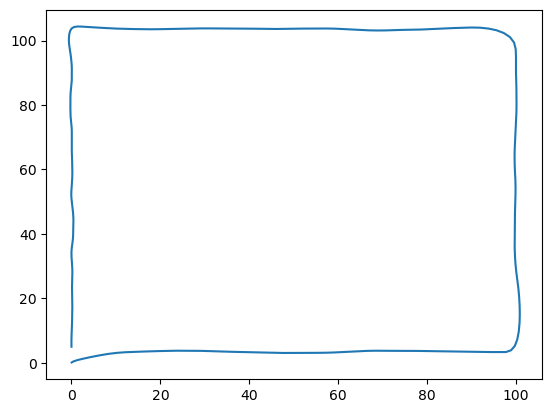

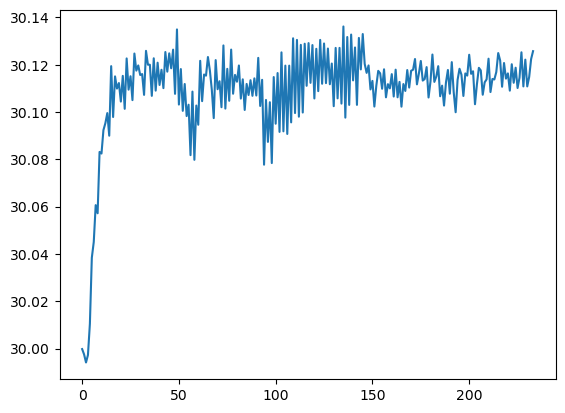

In [13]:
plt.plot(log.x, log.y)
plt.show()
plt.plot(log.z)

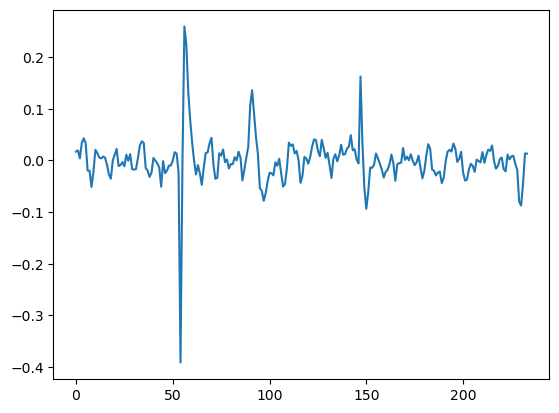

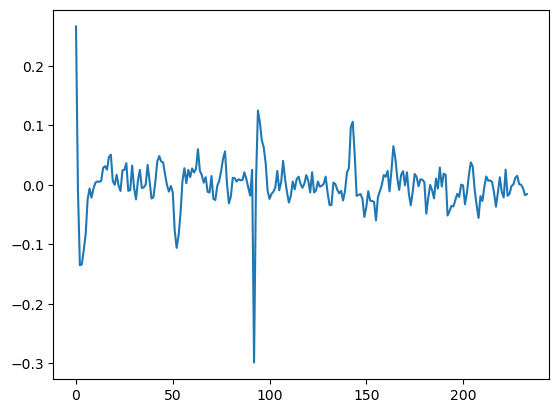

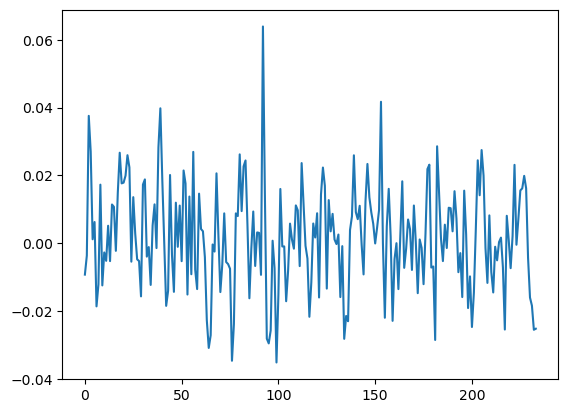

In [14]:
plt.plot(log.angular_rate[:,0])
plt.show()

plt.plot(log.angular_rate[:,1])
plt.show()

plt.plot(log.angular_rate[:,2])
plt.show()

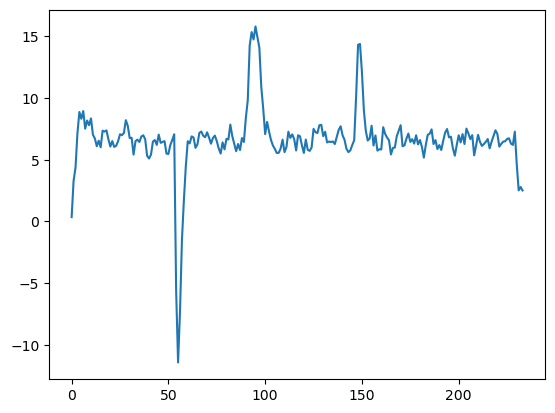

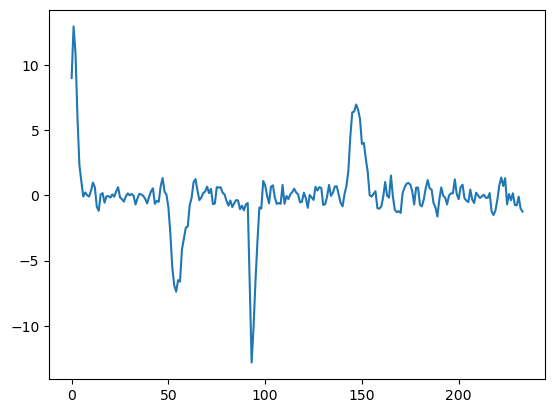

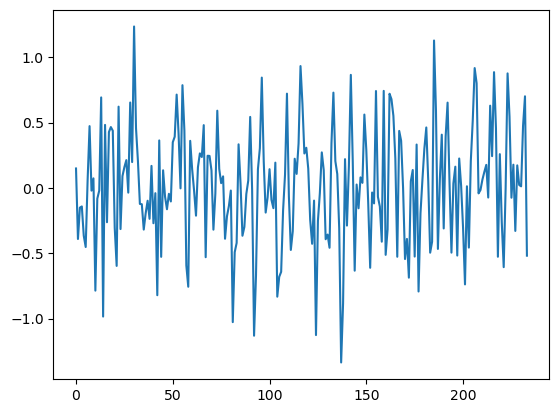

In [14]:
plt.plot(np.rad2deg(log.orientation[:,0]))
plt.show()

plt.plot(np.rad2deg(log.orientation[:,1]))
plt.show()

plt.plot(np.rad2deg(log.orientation[:,2]))
plt.show()

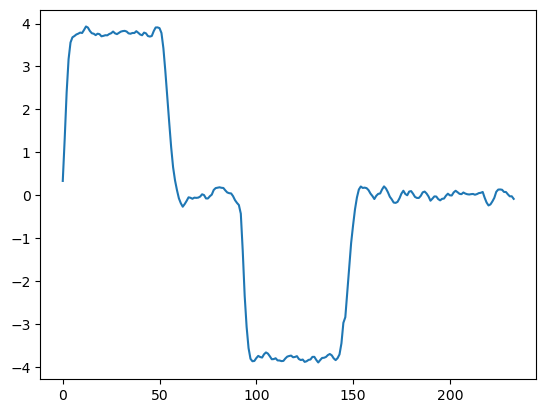

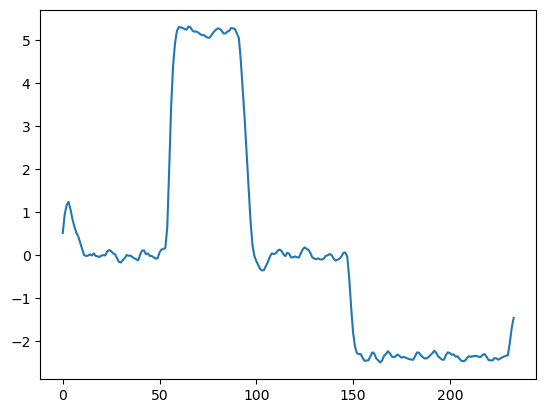

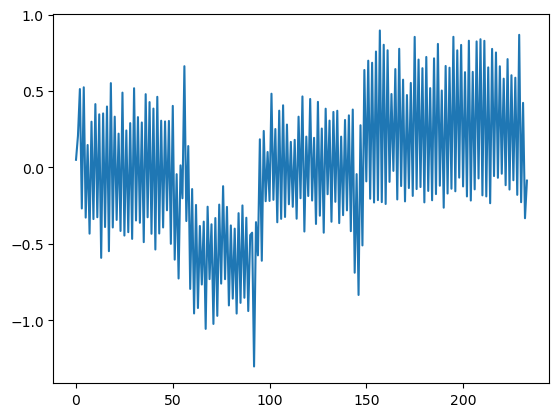

In [15]:
plt.plot(range(len(log)), log.velocity[:,0])
plt.show()

plt.plot(range(len(log)), log.velocity[:,1])
plt.show()

plt.plot(range(len(log)), log.velocity[:,2])
plt.show()

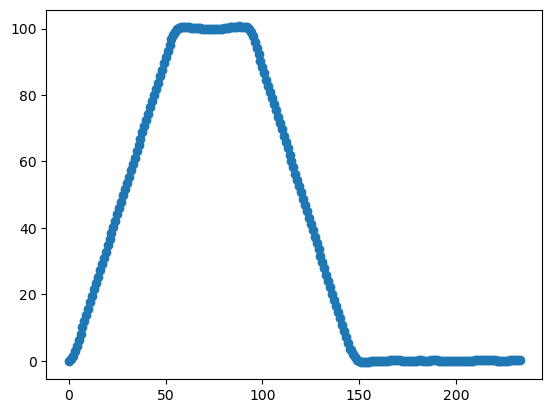

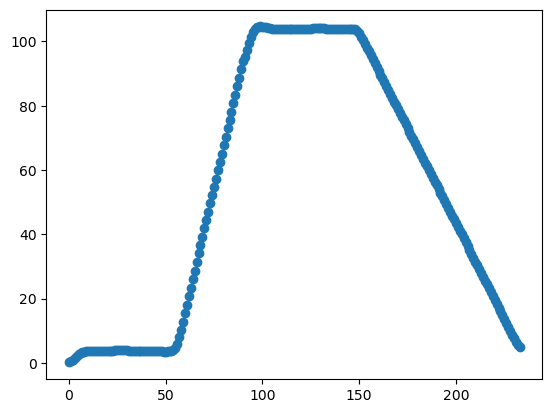

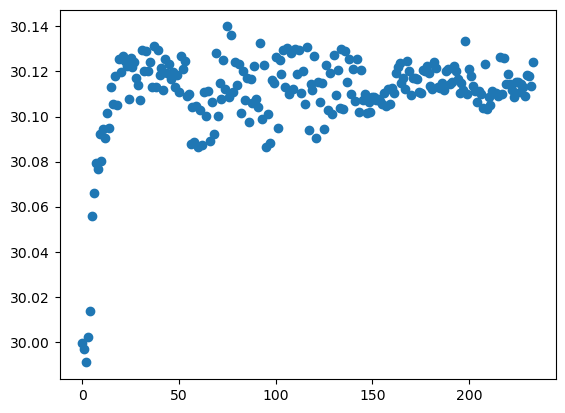

In [16]:
plt.scatter(range(len(log)), log.position[:,0])
plt.show()

plt.scatter(range(len(log)), log.position[:,1])
plt.show()

plt.scatter(range(len(log)), log.position[:,2])
plt.show()

In [12]:
wind_results = pd.DataFrame(columns=['Wind', 'Total TTE', 'Mean TTE', 'Completed Mission', 'Reward', 'Time Outside Corridor'])

In [11]:
def run_wind_sweep(results, wind_dict, agent, params):
    for wind in tqdm(wind_dict.keys()):
        log, info = run_trajectory(env_selector, wind_dict[wind], agent, params)
        traj_err = get_tte(np.array([0,0,0]), log.target.position, log.x, log.y, log.z)
        new_result = {
            'Wind': wind,
            'Mean TTE': np.mean(traj_err),
            'Total TTE': np.sum(traj_err),
            'Completed Mission': completed_mission(square_wpts, log.x, log.y, log.z, radius=5),
            'Reward': np.sum(log.reward),
            'Time Outside Corridor': toc(traj_err)
        }
        results = pd.concat([results, pd.DataFrame([new_result])], ignore_index=True)

    return results

In [12]:
wind_results = run_wind_sweep(wind_results, wind_range_dict, best_agent, best_params)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [02:19<00:00,  5.57s/it]


In [13]:
wind_results.to_csv('./data/pid_wind.csv')

In [2]:
wind_results = pd.read_csv('./data/pid_wind.csv') # or read cardinal_wind.csv for the Cardinal High agent

In [3]:
wind_results

,Unnamed: 0,Wind,Total TTE,Mean TTE,Completed Mission,Reward,Time Outside Corridor
0,0,zero,49.148851,0.230746,True,9441.6340,0.0
1,1,n5,224.837982,1.040917,True,7705.3540,0.0
2,2,n7,413.365530,1.774101,True,5866.3800,0.0
3,3,n10,2406.271781,8.020906,False,-26524.6560,147.5
4,4,s5,226.183666,1.042321,True,7707.1367,0.0
5,5,s7,412.914056,1.779802,True,5865.4385,0.0
6,6,s10,2406.271781,8.020906,False,-26524.6560,147.5
7,7,e5,227.616294,1.039344,True,7711.6610,0.0
8,8,e7,428.456475,1.823219,True,5756.8700,1.0
9,9,e10,6558.306178,19.873655,False,-65563.2340,148.5


In [4]:
print("Mean reward for 5 m/s: ", wind_results[wind_results['Wind'].str.contains("5")]['Reward'].mean())
print("Std reward for 5 m/s: ",wind_results[wind_results['Wind'].str.contains("5")]['Reward'].std())
print("Mean reward for 7 m/s: ", wind_results[wind_results['Wind'].str.contains("7")]['Reward'].mean())
print("Std reward for 7 m/s: ",wind_results[wind_results['Wind'].str.contains("7")]['Reward'].std())
print("Mean reward for 10 m/s: ", wind_results[wind_results['Wind'].str.contains("10")]['Reward'].mean())
print("Std reward for 10 m/s: ",wind_results[wind_results['Wind'].str.contains("10")]['Reward'].std())

Mean reward for 5 m/s:  7772.7666125
Std reward for 5 m/s:  69.01246392480626
Mean reward for 7 m/s:  5861.2837500000005
Std reward for 7 m/s:  62.231845910020816
Mean reward for 10 m/s:  -21712.696337499998
Std reward for 10 m/s:  19370.659020842333
